# Machine Learning - Trabalho prático 1

## Análise exploratória

In [24]:
import math

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import display

from types import SimpleNamespace as Object

### Sumário dos dados

In [2]:
data = pd.read_csv('koi_data.csv')

print('Número de linhas: {}'.format(data.shape[0]))
print('Número de colunas: {}'.format(data.shape[1]))
print('Dados faltantes: {}'.format(data.isnull().sum().sum()))

print('\nDataframe:')
data.info()

print('\nAmostra:')
with pd.option_context('max_columns', 5): # Limita o numero de cols mostradas
    display(data.head(5))

Número de linhas: 5202
Número de colunas: 43
Dados faltantes: 0

Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5202 entries, 0 to 5201
Data columns (total 43 columns):
kepoi_name          5202 non-null object
koi_disposition     5202 non-null object
koi_period          5202 non-null float64
koi_impact          5202 non-null float64
koi_duration        5202 non-null float64
koi_depth           5202 non-null float64
koi_ror             5202 non-null float64
koi_srho            5202 non-null float64
koi_prad            5202 non-null float64
koi_sma             5202 non-null float64
koi_incl            5202 non-null float64
koi_teq             5202 non-null float64
koi_insol           5202 non-null float64
koi_dor             5202 non-null float64
koi_max_sngle_ev    5202 non-null float64
koi_max_mult_ev     5202 non-null float64
koi_model_snr       5202 non-null float64
koi_steff           5202 non-null float64
koi_slogg           5202 non-null float64
koi_smet            5

,kepoi_name,koi_disposition,...,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,...,0.310,0.320
1,K00752.02,CONFIRMED,...,0.120,0.500
2,K00754.01,FALSE POSITIVE,...,0.099,0.276
3,K00755.01,CONFIRMED,...,0.020,0.070
4,K00114.01,FALSE POSITIVE,...,7.713,8.948


## Features
O *target* é a coluna `koi_disposition` que identifica se um corpo é de fato um exoplaneta.  
A coluna `kepoi_name` representa o nome de cada corpo, e portanto não constitui uma feature.

In [3]:
target = 'koi_disposition'

data = data.drop('kepoi_name', axis = 1)

features = list(data.columns)
features.remove(target)

Sendo o *target* um dado categórico, é necessário codificá-lo.  
Como existem apenas dois valores, uma codificação binária é o suficiente.

In [4]:
print('Target: ' + target)

encoding = {
  label: i
  for i, label in enumerate(data[target].unique())
}

display(pd.DataFrame.from_dict(encoding, orient = 'index', columns = ['encoding']))
print()

data[target] = data[target].map(encoding)

display(
  (data[target].value_counts() * 100 / len(data))
    .round(2)
    .to_frame(target +' (%)')
    .T
)

Target: koi_disposition


,encoding
CONFIRMED,0
FALSE POSITIVE,1


,1,0
koi_disposition (%),59.55,40.45


Features:


/usr/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


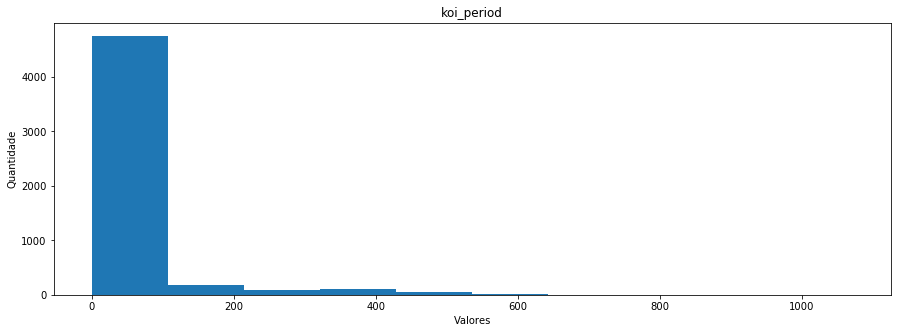

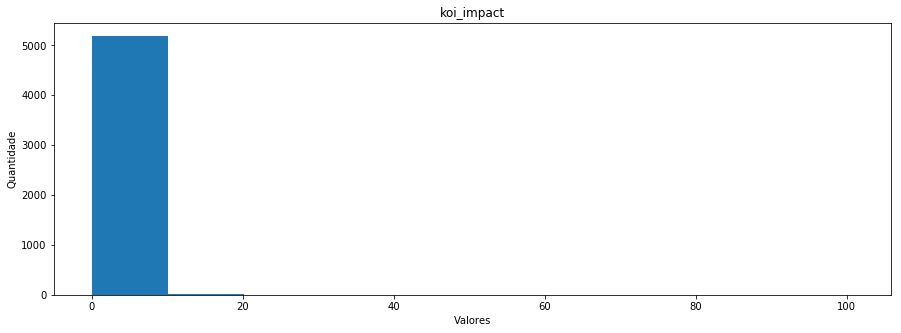

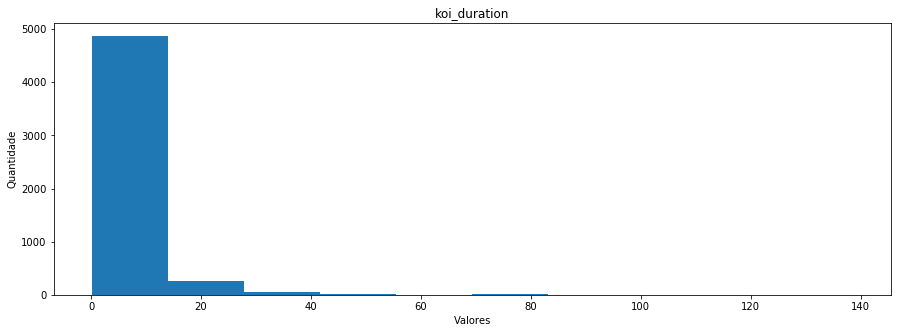

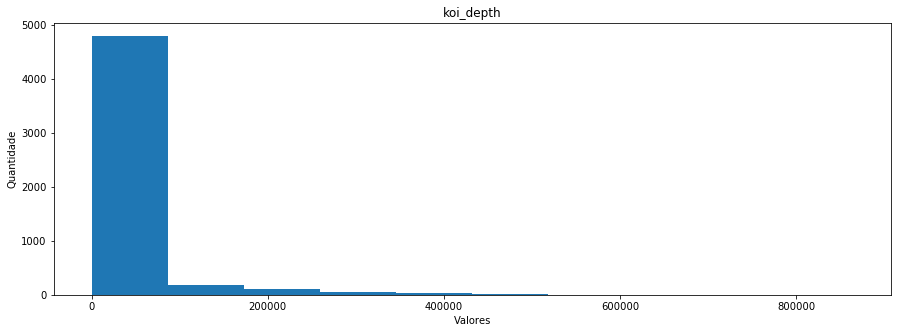

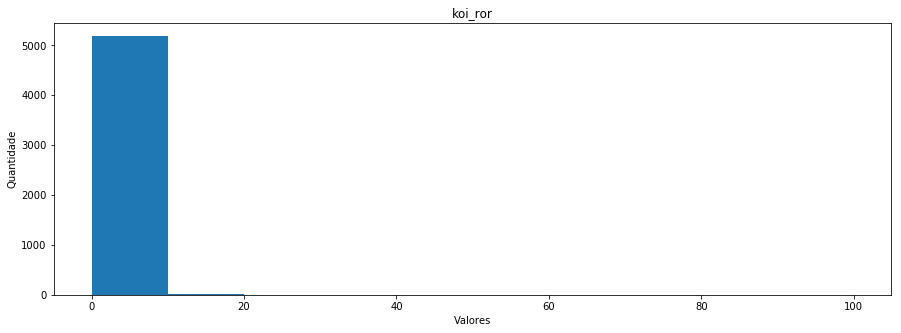

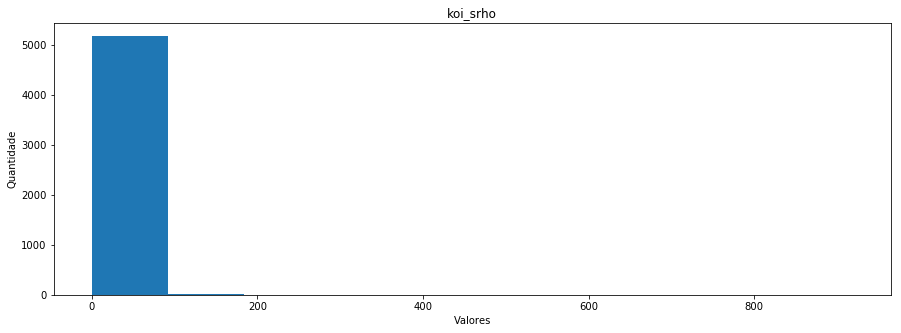

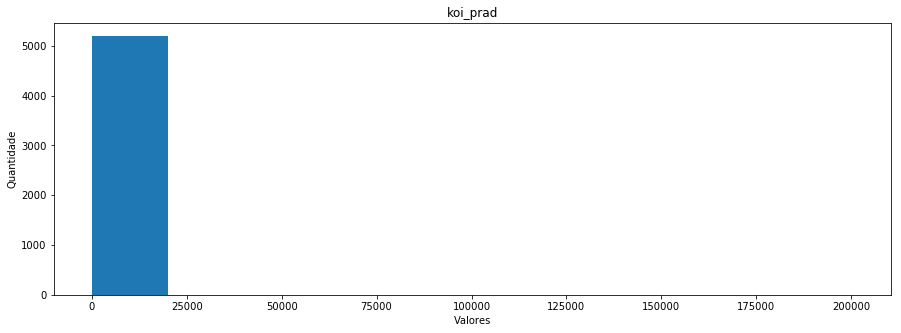

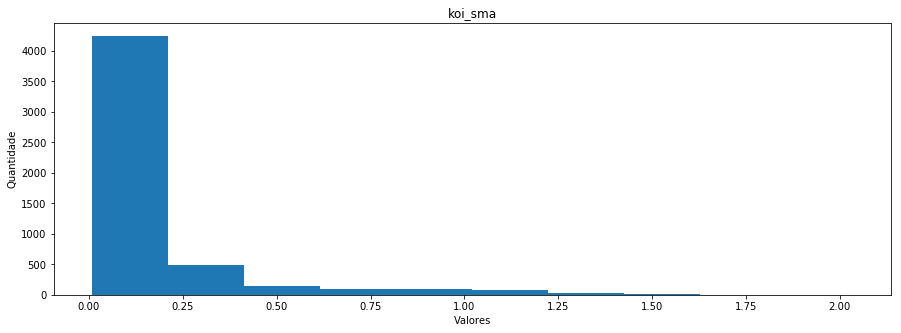

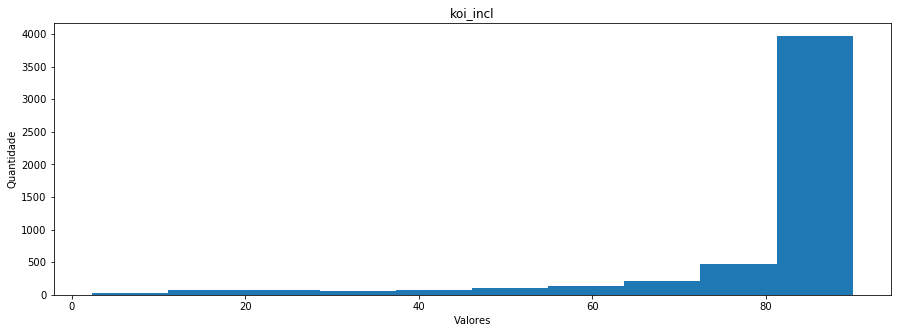

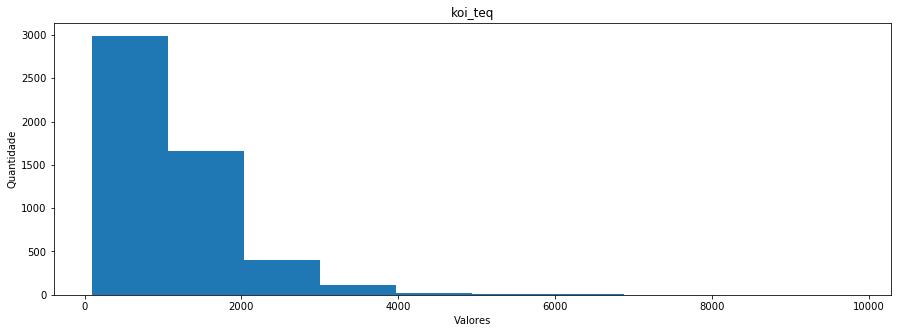

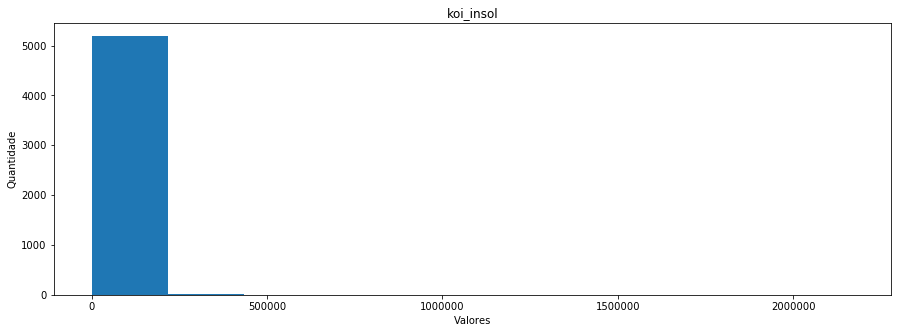

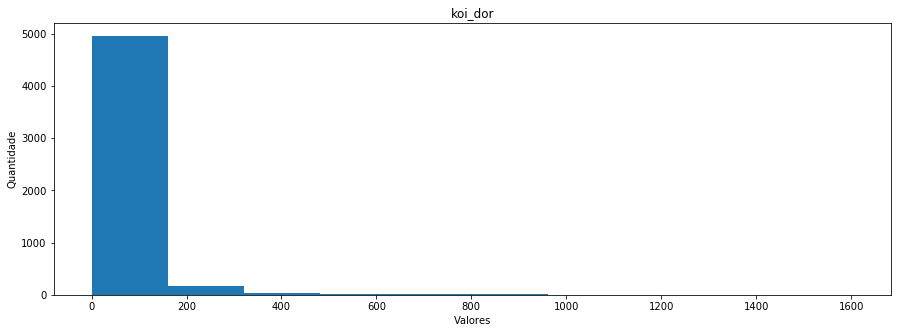

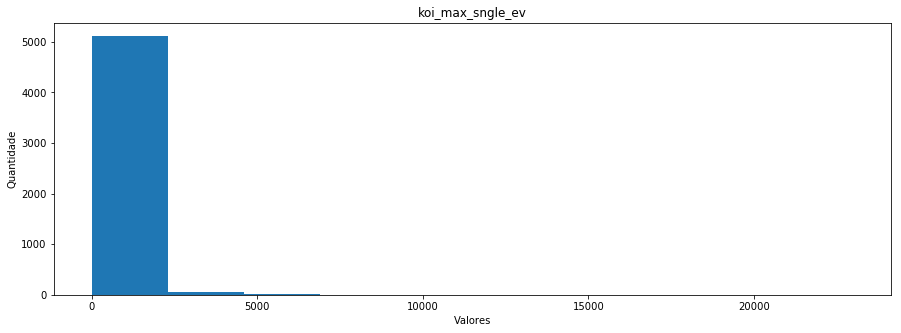

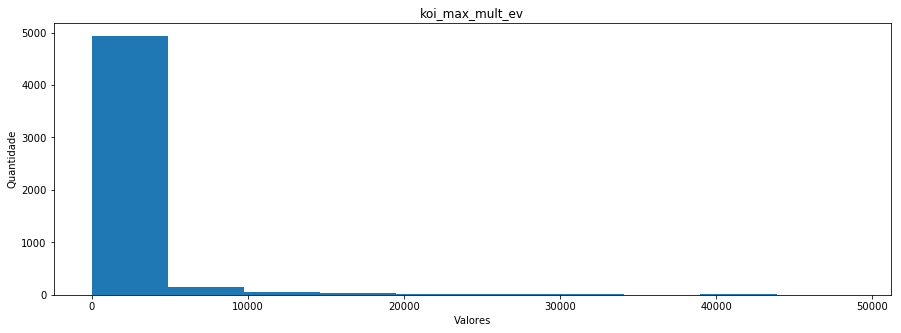

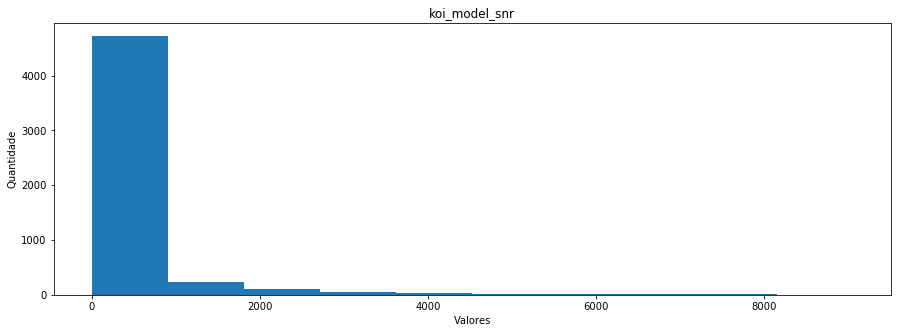

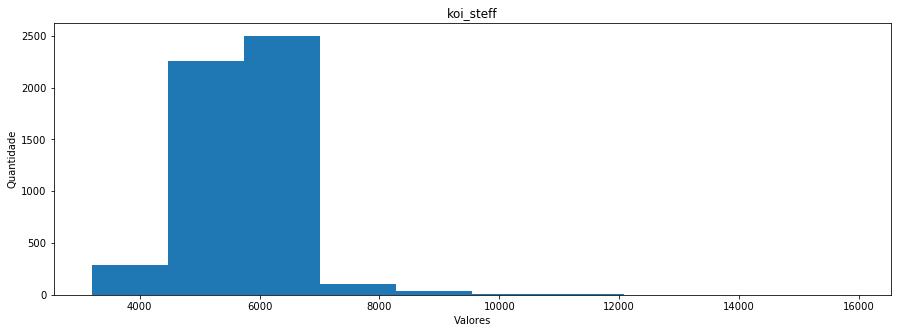

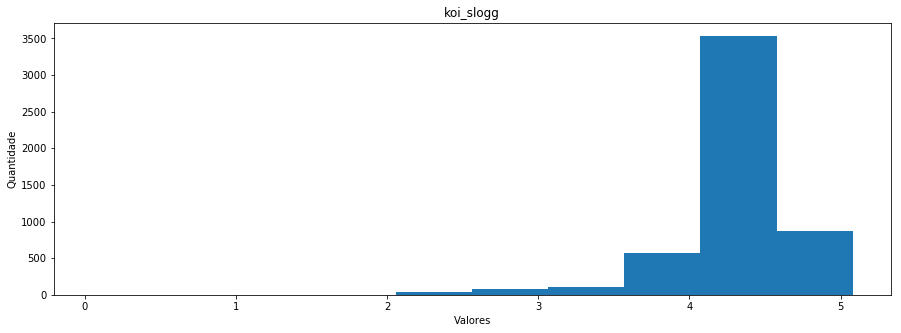

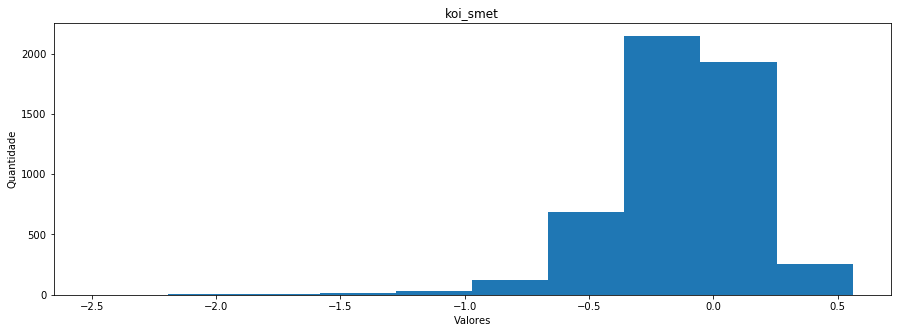

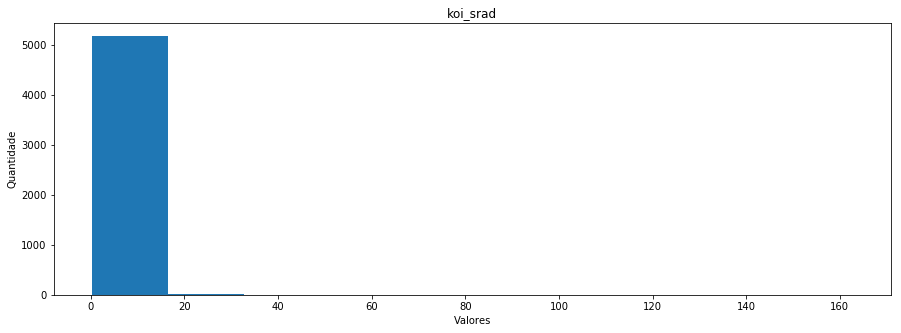

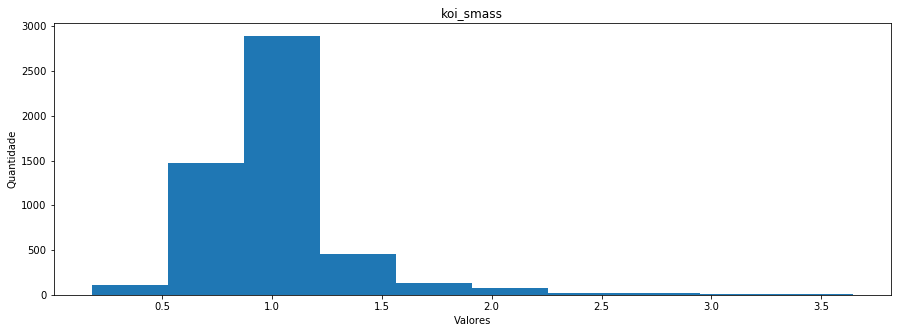

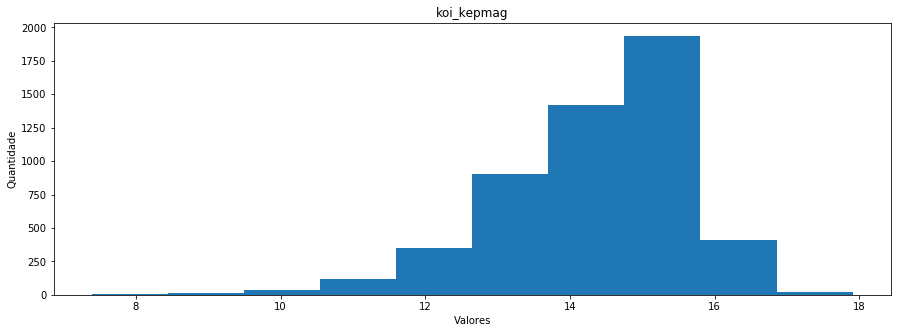

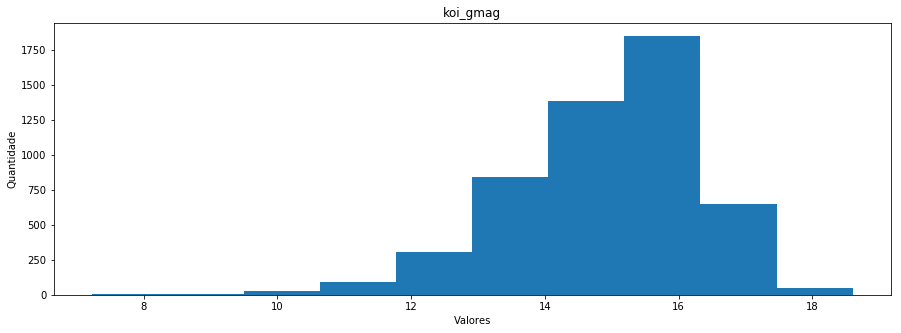

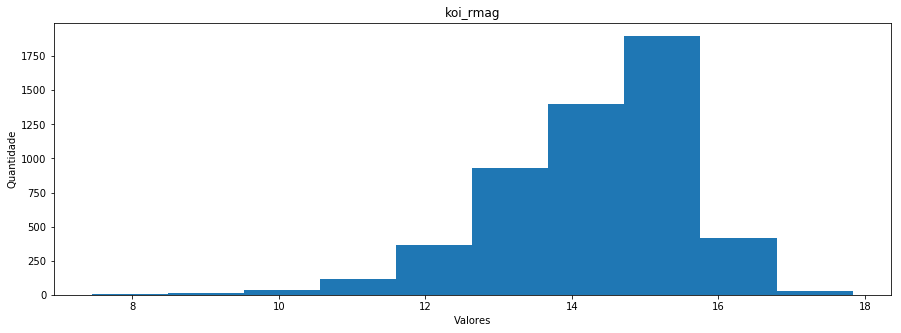

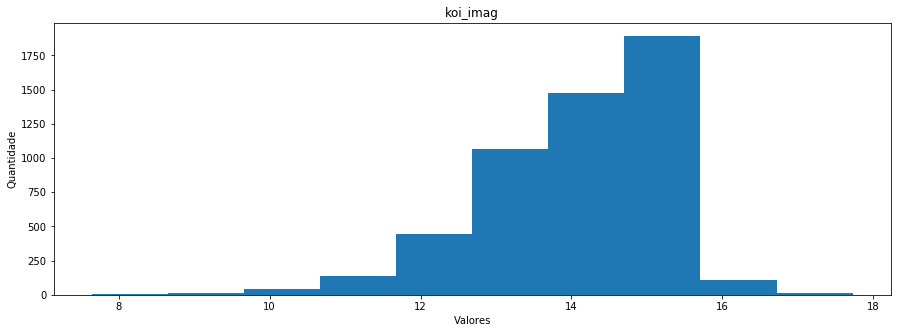

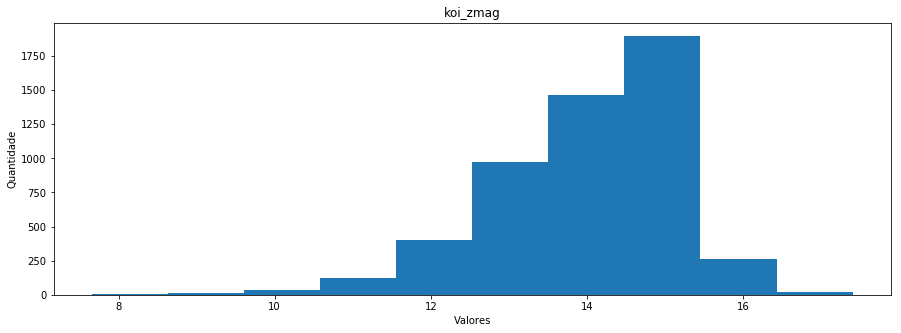

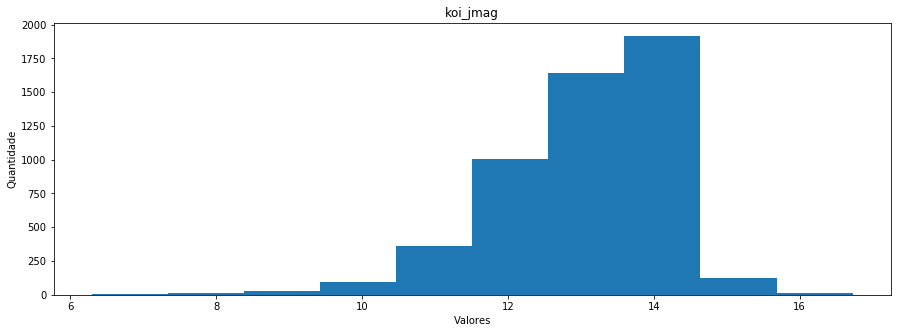

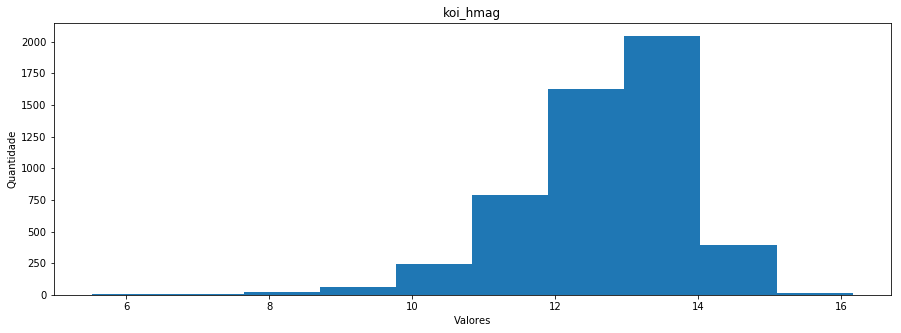

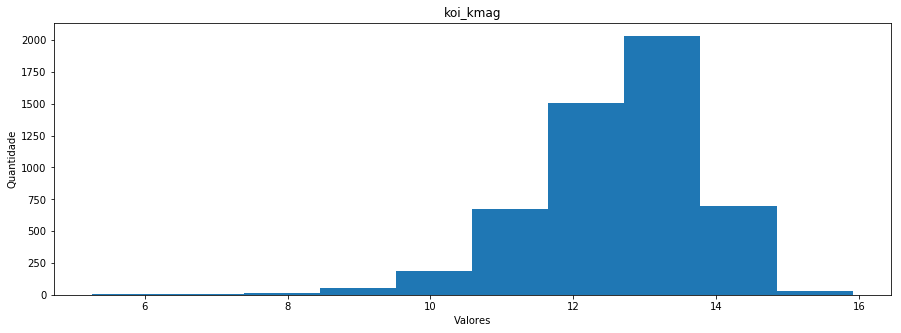

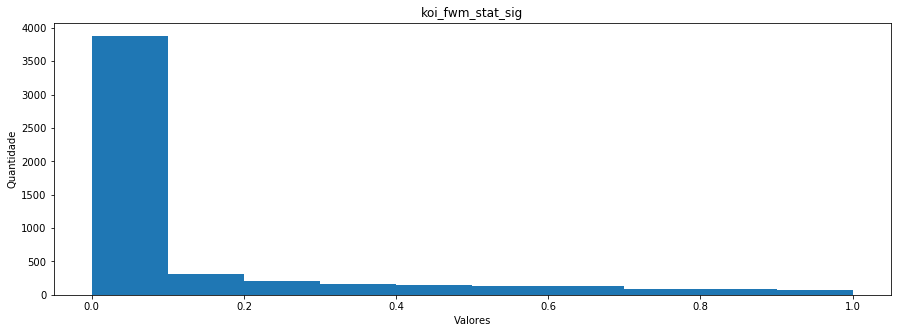

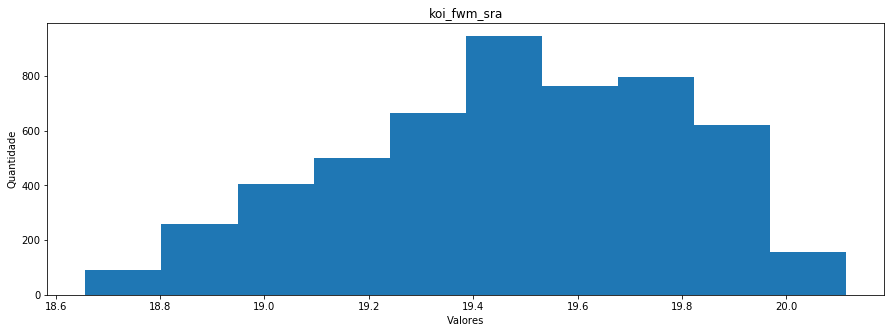

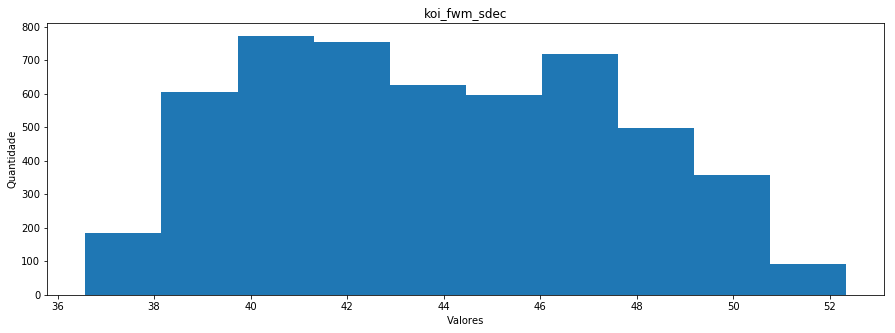

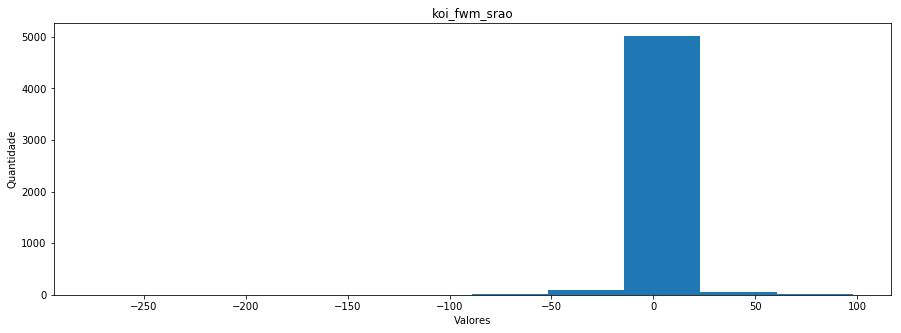

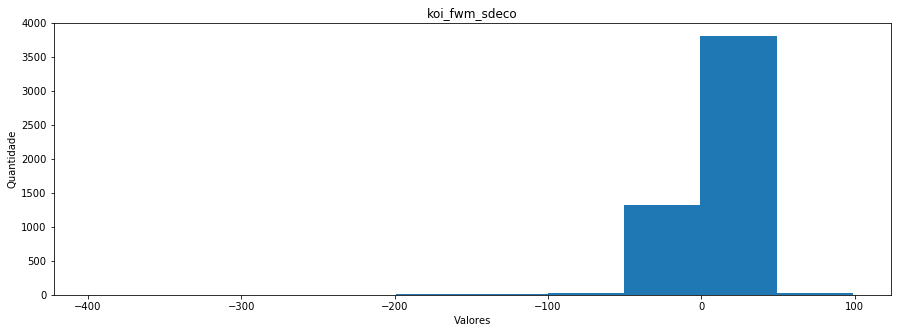

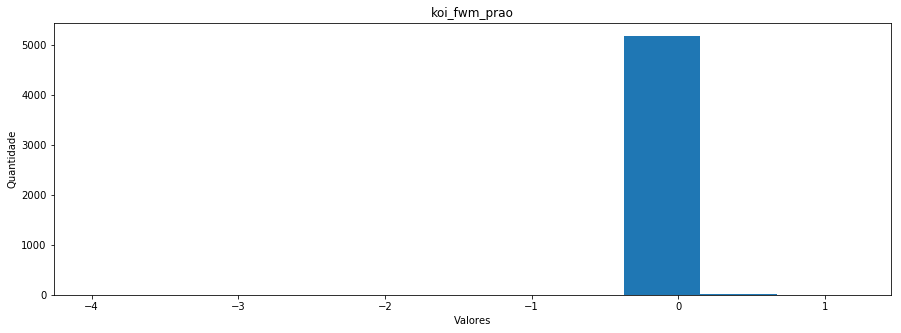

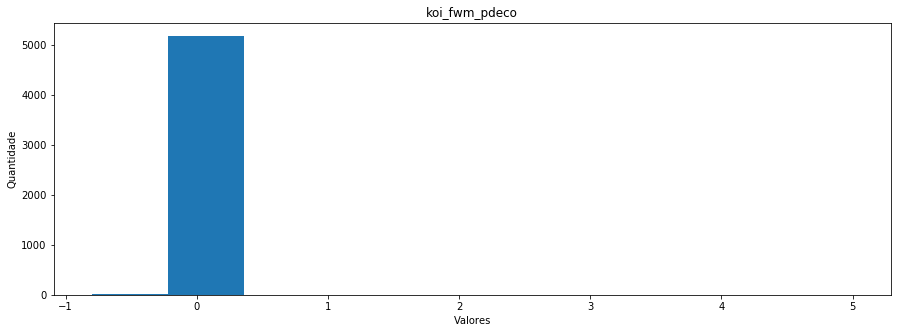

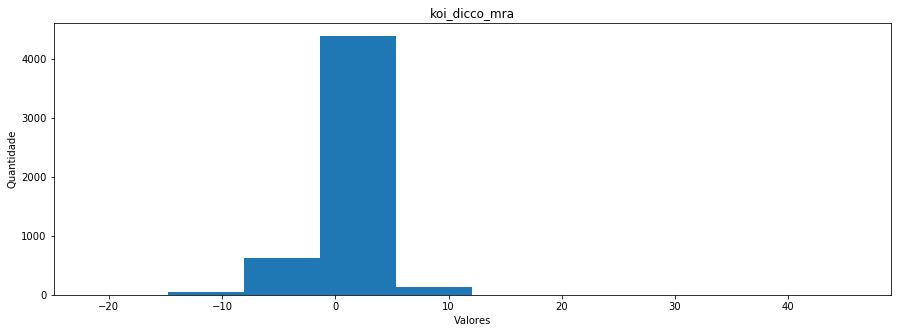

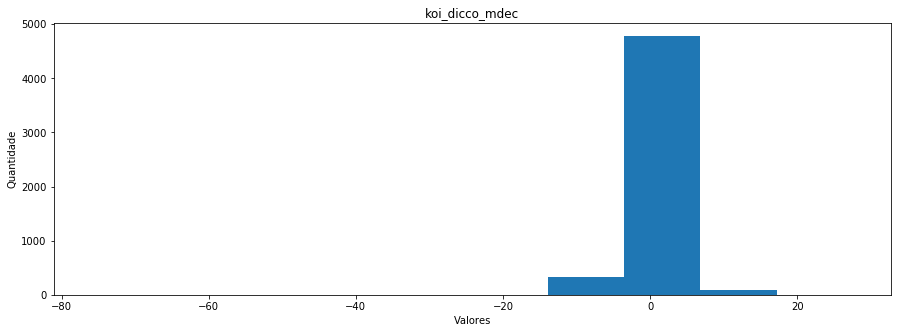

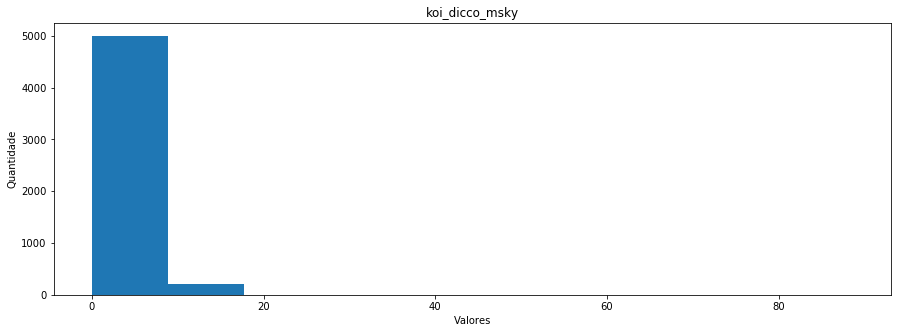

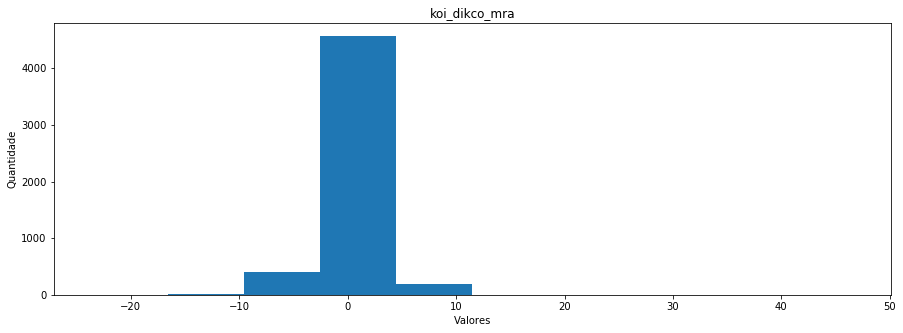

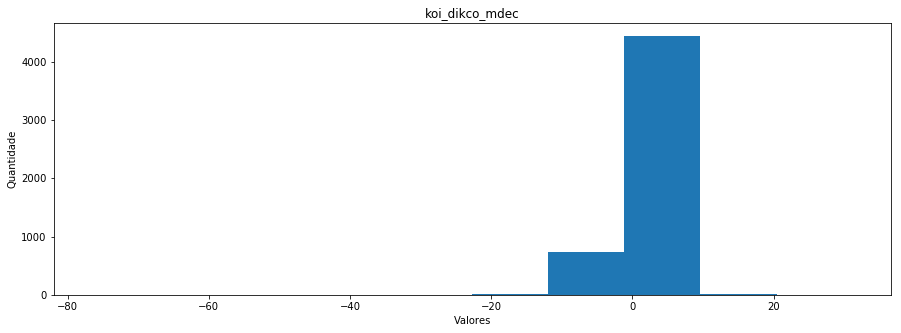

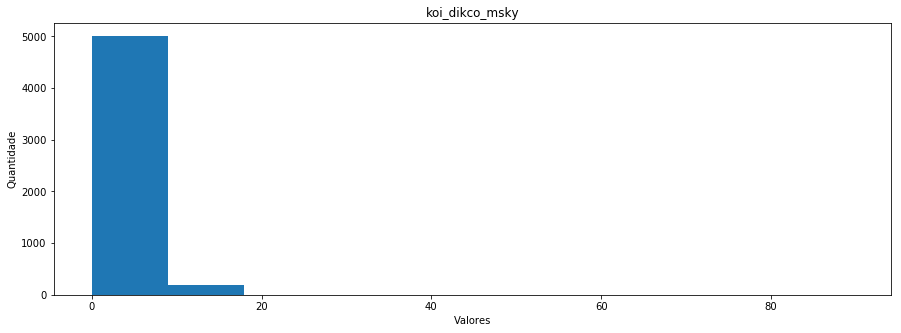

In [5]:
print('Features:')

for f in features:
    plt.figure(figsize=(15, 5))
    plt.hist(data[f])
    plt.title(f)
    plt.xlabel('Valores')
    plt.ylabel('Quantidade')
    # plt.yscale('log', nonposy='clip')
    # plt.grid()

plt.show()

### Normalização
Não há dados com o desvio padrão próximo de zero, portanto é seguro subtrair a média e
dividir pelo desvio padrão.  
Além disso, não há dados faltantes, portanto não é necessário o tratamento deste tipo de
anomalia.

In [6]:
print(
  'Colunas com desvio padrão próximo de zero: ',
  data[features]
    .std()
    .apply(lambda x: math.isclose(x, 0))
    .sum()
)

data[features] = data[features] - data[features].mean()

data[features] = data[features] / data[features].std()

Colunas com desvio padrão próximo de zero:  0


## Definição da validação

In [54]:
from sklearn.model_selection import KFold

N_FOLDS = 5

kfold = KFold(n_splits = N_FOLDS)

def cross_validate(alg):
  train_accuracies = []
  test_accuracies = []

  for train, test in kfold.split(data):
    train = data.iloc[train]
    test  = data.iloc[test]

    model = alg.fit(train[features], train[target])

    train_accuracies.append(
      model.score(train[features], train[target])
    )

    test_accuracies.append(
      model.score(test[features], test[target])
    )

    # display(
    #   test[target]
    #     .to_frame('target')
    #     .reset_index()
    #     .join(pd.DataFrame({ 'prediction' : prediction }))
    # )

  return Object(
    train = np.mean(train_accuracies),
    test = np.mean(test_accuracies)
  )

## Modelos

### Naive Bayes
Como baseline, utilizaremos o Naive Bayes com curva gaussiana.

In [55]:
from sklearn.naive_bayes import GaussianNB

gnb = Object()

gnb.algorithm = GaussianNB()

gnb.accuracy = cross_validate(gnb.algorithm)

print('Train accuracy: {:.3f}'.format(gnb.accuracy.train))
print('Test accuracy: {:.3f}'.format(gnb.accuracy.test))

Train accuracy: 0.917
Test accuracy: 0.916


### Decision Tree
Nas árvores de decisão, a altura é diretamente proporcional à complexidade do modelo.
Portanto, quanto mais alta a árvore, mais *overfitting* ocorre.

In [67]:
from sklearn.tree import DecisionTreeClassifier

dtc = {
  i or len(heights): Object(
    algorithm = algorithm,
    accuracy = cross_validate(algorithm)
  )
  for heights in [ [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None ] ]
  for i in heights
  for algorithm in [ DecisionTreeClassifier(max_depth = i) ]
}

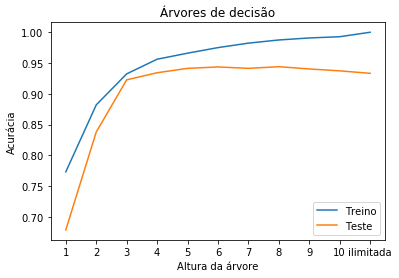

In [69]:
x, y = zip(
  *sorted(
    (depth, (tree.accuracy.train, tree.accuracy.test))
      for depth, tree in dtc.items()
  )
)

plt.title('Árvores de decisão')
plt.xlabel('Altura da árvore')
plt.ylabel('Acurácia')
plt.xticks(
  x,
  [ str(i) for i in x[:-1] ] + ['ilimitada']
)
plt.plot(x, y)
plt.legend([ 'Treino', 'Teste' ], loc = 'lower right')
plt.show()

### SVM

In [82]:
from sklearn.svm import SVC

svm = {
  kernel: Object(
    algorithm = algorithm,
    accuracy = cross_validate(algorithm) 
  )
  for kernel in [ 'linear', 'sigmoid', 'poly', 'rbf' ]
  for algorithm in [ SVC(kernel = kernel, gamma = 'auto') ]
}

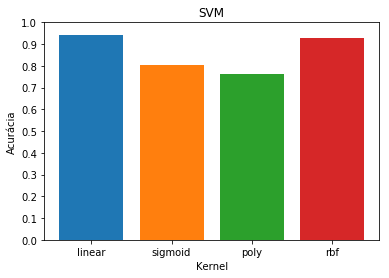

In [96]:
plt.title('SVM')
plt.xlabel('Kernel')
plt.ylabel('Acurácia')

for kernel, algorithm in svm.items():
  plt.bar(kernel, algorithm.accuracy.test)

plt.yticks(np.arange(0, 1.1, 0.1))

plt.show()

### kNN

### Random Forest

In [110]:
from sklearn.ensemble import RandomForestClassifier

rfc = {
  n: Object(
    algorithm = algorithm,
    accuracy = cross_validate(algorithm)
  )
  for n in range(2, 13, 2)
  for algorithm in [ RandomForestClassifier(n_estimators = n) ]
}

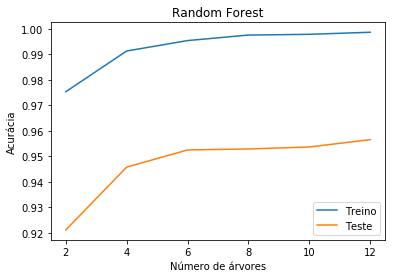

In [111]:
x, y = zip(
  *sorted(
    (n, (forest.accuracy.train, forest.accuracy.test))
      for n, forest in rfc.items()
  )
)

plt.title('Random Forest')
plt.xlabel('Número de árvores')
plt.ylabel('Acurácia')

plt.plot(x, y)
plt.xticks(x)
plt.legend([ 'Treino', 'Teste' ], loc = 'lower right')
plt.show()

### Gradient Tree Boosting